In [414]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [415]:
%cd drive/MyDrive/competitions/probspace_pricing/notebooks

[Errno 2] No such file or directory: 'drive/MyDrive/competitions/probspace_pricing/notebooks'
/content/drive/MyDrive/competitions/probspace_pricing/notebooks


In [416]:
!pip install lightgbm==3.3.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [417]:
import glob
from IPython.display import display
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
#import japanize_matplotlib
import seaborn as sns 
pd.set_option("display.max_columns",200)
pd.set_option("display.max_rows", 500)

In [418]:
import lightgbm as lgb
from sklearn.model_selection import ShuffleSplit

In [419]:
from sklearn.metrics import mean_absolute_percentage_error

In [420]:
import datetime

# データの準備

In [421]:
# データの読み込み
feature_dir = "../data/features/"
train = pd.read_pickle(feature_dir + "train.pkl")
test = pd.read_pickle(feature_dir + "test.pkl")
print(train.shape)

(39475, 160)


In [422]:
def prep_change_obj_category(all_df):
    """カテゴリ変数の型を"category"に変換
    """

    # カテゴリ変数のカラムを抽出
    obj_cats = all_df.dtypes[all_df.dtypes=="object"].index

    # categoryにキャスト
    for cat in obj_cats:
        all_df[cat] = all_df[cat].astype("category")

    return all_df

In [423]:
train = prep_change_obj_category(train)
test = prep_change_obj_category(test)

In [424]:
# データの分割
test_x = test.drop(columns=["Price"])
train_x = train.drop(columns=["Price"])
train_y = train["Price"]

In [425]:
# 評価指標がMAEのため、あらかじめ目的変数に対数変換を施しておく
# train_y = np.log1p(train_y)

# カテゴリ変数を抽出
# categoryにキャスト
categorical_features = list(train.dtypes[train.dtypes=="category"].index)

# カスタム評価関数・目的関数

In [426]:
def fair(preds, dtrain):
    """Fair関数
    """
    # 残差を取得
    x = preds - dtrain.get_label()
    # Fair関数のパラメータ
    c = 1.0
    # 勾配の式の分母
    den = abs(x) + c
    # 勾配
    grad = c * x / den
    # 二階微分値
    hess = c * c / den ** 2

    return grad, hess

In [427]:
def mape(preds, dtrain):
    """MAPE
    """
    labels = dtrain.get_label()
    # 対数変換を戻す
    preds = np.expm1(preds)
    labels = np.expm1(labels)
    # スコアを計算
    eval_result = mean_absolute_percentage_error(labels, preds)

    return "mape_eval", eval_result, False

# モデルの定義と学習

In [428]:
%%time
params = {
    'boosting_type': 'gbdt', # fairとするとこれがないとうまくいかない
    # 'objective': 'fair', # 目的関数
    # 'metric': "mape", # 評価関数
    "learning_rate": 0.1,
    # "deterministic": True,
    # "feature_pre_filter": False,
    "lambda_l1": 1.0, #2.471598727553709e-07,
    "lambda_l2": 1.0, #7.067019500748873e-07,
    "num_leaves": 31, # 1本の木の葉の最大数
    "feature_fraction": 0.8, # 決定木ごとに特徴量の列をサンプリングする割合
    "bagging_fraction": 1.0, # 決定木ごとに特徴量の行をサンプリングする割合
    "bagging_freq": 0, # baggingでデータサンプリングする頻度、０の場合はbaggingしない
    "min_child_samples": 20, # 1枚の葉の最小データ数
    'early_stopping_rounds': 200,
    'num_boost_round': 10000,
}

cv = lgb.cv(
    params = params,
    train_set = lgb.Dataset(train_x, label = train_y),
    folds = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0),
    categorical_feature=categorical_features,
    seed = 0,
    return_cvbooster = True,
    fobj=fair,
    feval=mape,
    verbose_eval=True,
    metrics="None",
)

model = cv["cvbooster"]

Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['AreaCategory', 'Availability', 'Bathrooms_type', 'City', 'Country', 'Description_lang', 'HasPicture', 'IdentityVerified', 'InstantBookable', 'OwnerDetail_lang', 'RoomType', 'TimeToReply']


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25648
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 156
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25648
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 156
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	cv_agg's mape_eval: 0.72685 + 0.00540429
[2]	cv_agg's mape_eval: 0.633962 + 0.00326057
[3]	cv_agg's mape_eval: 0.569319 + 0.00268958
[4]	cv_agg's mape_eval: 0.519731 + 0.00210799
[5]	cv_agg's mape_eval: 0.498125 + 0.00204575
[6]	cv_agg's mape_eval: 0.465094 + 0.00159412
[7]	cv_agg's mape_eval: 0.439549 + 0.00135407
[8]	cv_agg's mape_eval: 0.428636 + 0.00133532
[9]	cv_agg's mape_eval: 0.409554 + 0.00144908
[10]	cv_agg's mape_eval: 0.401834 + 0.00170503
[11]	cv_agg's mape_eval: 0.395484 + 0.00184775
[12]	cv_agg's mape_eval: 0.382082 + 0.00201659
[13]	cv_agg's mape_eval: 0.377763 + 0.00202105
[14]	cv_agg's mape_eval: 0.366913 + 0.00200186
[15]	cv_a

# 評価

In [429]:
# エポック数
len(cv["mape_eval-mean"])

625

In [430]:
# CVの平均値
print(cv["mape_eval-mean"].pop())
# CVの標準偏差
print(cv["mape_eval-stdv"].pop())

0.2697319066879931
0.0033427246968825205


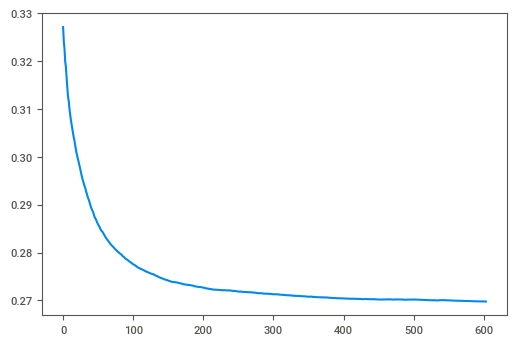

In [431]:
# 学習曲線(評価関数)
plt.plot(cv["mape_eval-mean"][20:])

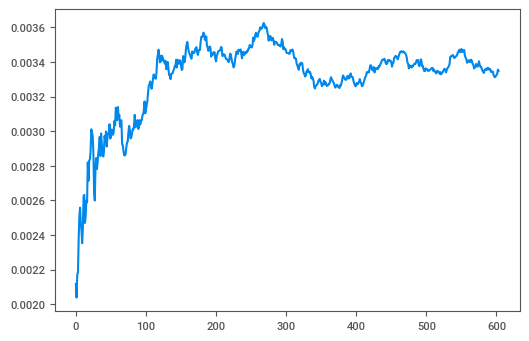

In [432]:
# 標準偏差
plt.plot(cv["mape_eval-stdv"][20:])

# モデルEDA

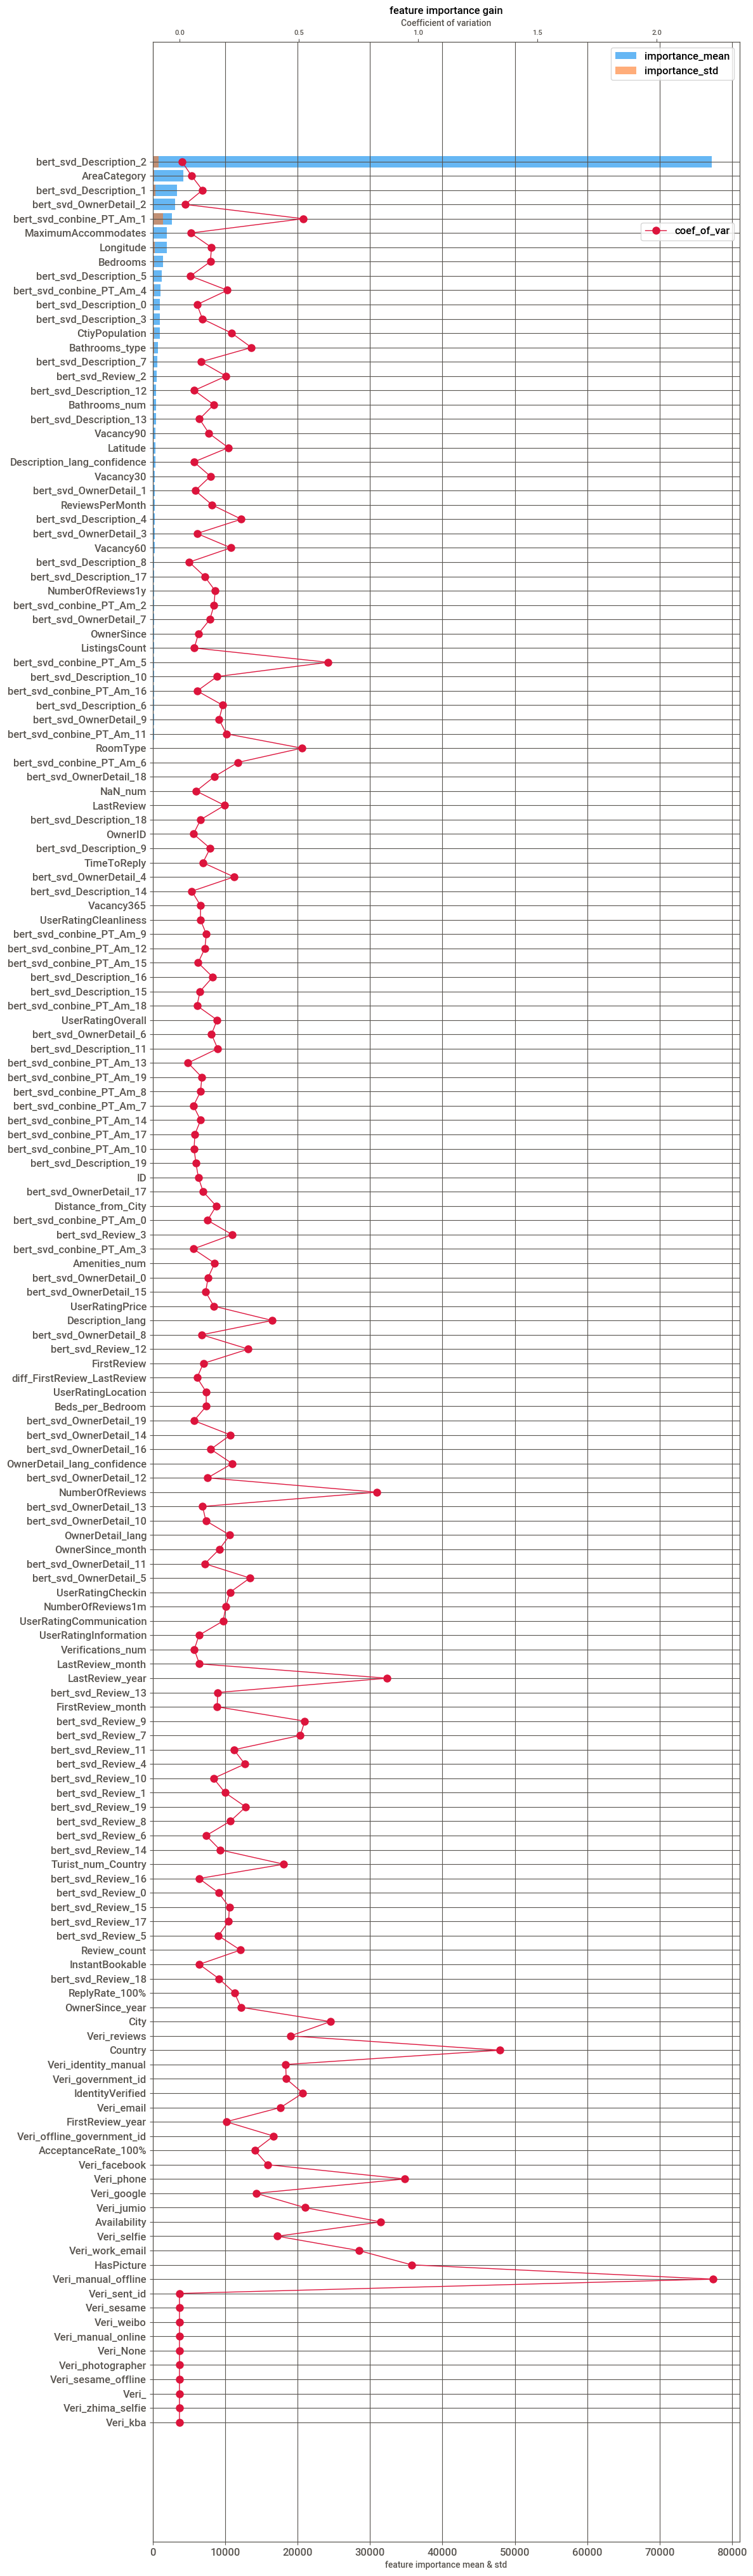

In [433]:
def calc_feature_importance(cv_model, features):
    """feature importanceの計算,図の保存
    """
    # 重要度の取得
    val_gain = pd.DataFrame(data=model.feature_importance(importance_type='gain'),
                            columns=model.boosters[0].feature_name()).T

    # 各foldの平均を算出
    val_mean = val_gain.mean(axis=1)
    val_mean = val_mean.values
    importance_df_mean = pd.DataFrame(val_mean, index=features, columns=['importance']).sort_values('importance')

    # 各foldの標準偏差を算出
    val_std = val_gain.std(axis=1)
    val_std = val_std.values
    importance_df_std = pd.DataFrame(val_std, index=features, columns=['importance']).sort_values('importance')

    # マージ
    df = pd.merge(importance_df_mean, importance_df_std, left_index=True, right_index=True ,suffixes=['_mean', '_std'])

    # 変動係数を算出
    df['coef_of_var'] = df['importance_std'] / df['importance_mean']
    df['coef_of_var'] = df['coef_of_var'].fillna(0)
    df = df.sort_values('importance_mean', ascending=True)

    # 出力
    fig, ax1 = plt.subplots(figsize = (10, 40))
    plt.tick_params(labelsize=12) # 図のラベルのfontサイズ
    plt.tight_layout()
    # 棒グラフを出力
    ax1.set_title('feature importance gain')
    ax1.set_xlabel('feature importance mean & std')
    ax1.barh(df.index, df['importance_mean'], label='importance_mean',  align="center", alpha=0.6)
    ax1.barh(df.index, df['importance_std'], label='importance_std',  align="center", alpha=0.6)
    # 折れ線グラフを出力
    ax2 = ax1.twiny()
    ax2.plot(df['coef_of_var'], df.index, linewidth=1, color="crimson", marker="o", markersize=8, label='coef_of_var')
    ax2.set_xlabel('Coefficient of variation')
    # 凡例を表示（グラフ左上、ax2をax1のやや下に持っていく）
    ax1.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.5, fontsize=12)
    ax2.legend(bbox_to_anchor=(1, 0.93), loc='upper right', borderaxespad=0.5, fontsize=12)
    # グリッド表示(ax1のみ)
    ax1.grid(True)
    ax2.grid(False)


calc_feature_importance(cv_model=model, features=model.boosters[0].feature_name())

# 予測値EDA

In [337]:
# 訓練データに対する予測値
train_preds = np.array(model.predict(train_x))
true = train_y.values
# 対数変換を戻す
train_preds = np.expm1(train_preds)
true = np.expm1(true)
# dfに格納
train_preds_df = pd.DataFrame({"preds": train_preds.mean(axis=0),
                                 "true": true})
train_preds_df

,preds,true
0,1187.542622,898.0
1,17645.214140,609213.0
2,4601.320349,3631.0
3,5082.229908,5697.0
4,3552.629286,2548.0
...,...,...
39470,27143.415100,31588.0
39471,10344.321011,8429.0
39472,12770.175504,11671.0
39473,4519.854363,5000.0


In [338]:
# MAPE
mean_absolute_percentage_error(train_preds_df["preds"], train_preds_df["true"])

0.19390718033062554

(0.0, 200000.0)

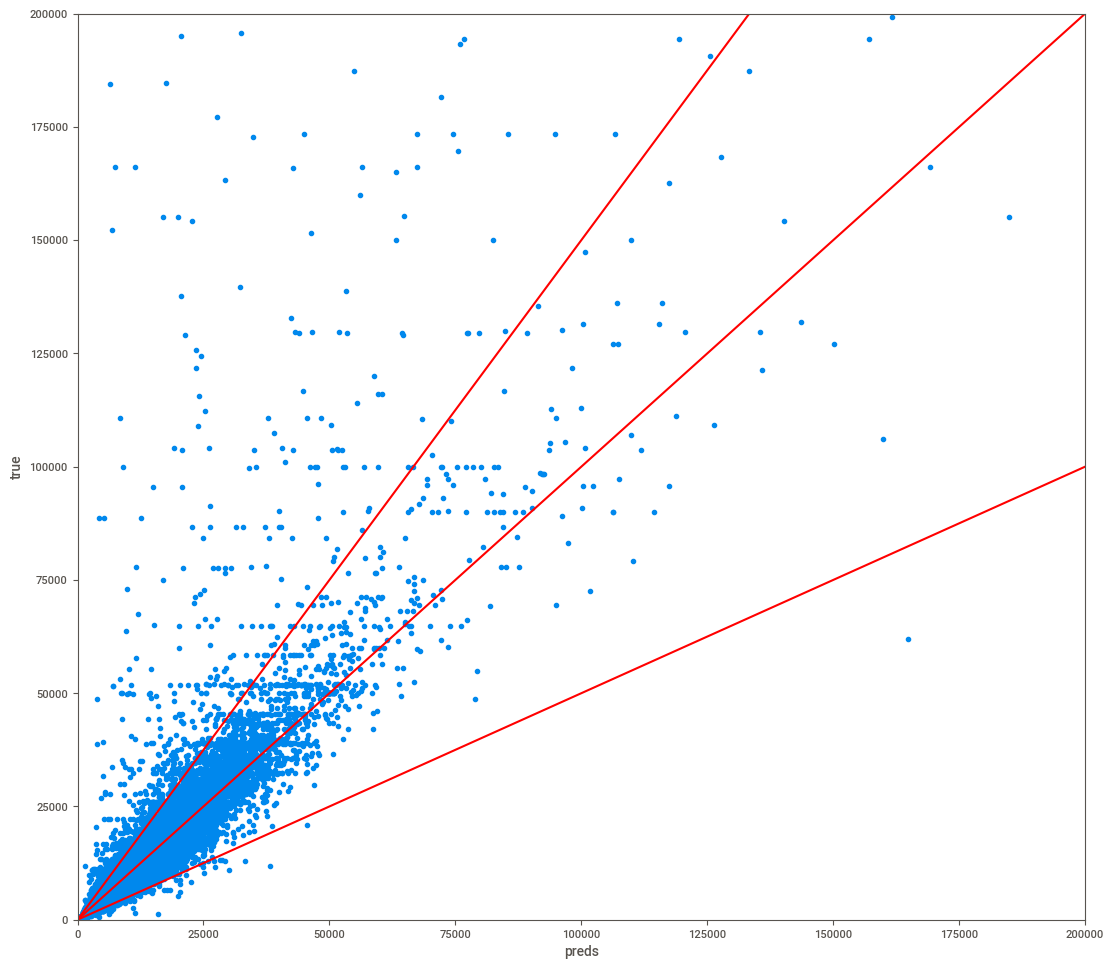

In [339]:
# 予測値と正解地との関係
plt.figure(figsize=(13,12))
plt.scatter(train_preds_df["preds"], train_preds_df["true"], )

x = np.array(range(1, 200000))
plt.plot(x, x*1.5, color="red")
plt.plot(x, x, color="red")
plt.plot(x, x*0.5, color="red")

plt.ticklabel_format(style='plain',axis='y')
plt.xlabel('preds')
plt.ylabel('true')
min, max = 0, 200000
plt.xlim(min, max)
plt.ylim(min, max)

In [340]:
# apeが０．５以上の予測値
df_over05 = train_preds_df[(train_preds_df["preds"]>train_preds_df["true"]*1.5) |
                           (train_preds_df["preds"]<train_preds_df["true"]*0.5)]
df_over05up = train_preds_df[(train_preds_df["preds"]>train_preds_df["true"]*1.5)]
df_over05dw = train_preds_df[(train_preds_df["preds"]<train_preds_df["true"]*0.5)]
# apeが０．５以下の予測値
df_under05 = train_preds_df[(train_preds_df["preds"]<train_preds_df["true"]*1.5) &
                            (train_preds_df["preds"]>train_preds_df["true"]*0.5)]

In [341]:
df_over05

,preds,true
1,17645.214140,609213.0
19,15120.741894,9414.0
52,10101.236181,6682.0
59,11102.545547,2689.0
65,3370.756730,2215.0
...,...,...
39437,1525.832546,910.0
39440,16167.056571,10374.0
39442,19218.633336,50000.0
39444,7243.293908,4432.0


In [342]:
# apeが０．５以下のMape
mean_absolute_percentage_error(df_under05["preds"],df_under05["true"])

0.14208624371629083

In [343]:
train["Preds"] = train_preds_df["preds"]
train.iloc[df_over05.index]

,ID,OwnerID,OwnerSince,TimeToReply,IdentityVerified,ListingsCount,HasPicture,RoomType,MaximumAccommodates,InstantBookable,Bedrooms,AreaCategory,Latitude,Longitude,Availability,Vacancy30,Vacancy60,Vacancy90,Vacancy365,UserRatingOverall,UserRatingInformation,UserRatingCleanliness,UserRatingCheckin,UserRatingCommunication,UserRatingLocation,UserRatingPrice,NumberOfReviews,NumberOfReviews1m,NumberOfReviews1y,FirstReview,LastReview,ReviewsPerMonth,Price,NaN_num,OwnerSince_year,OwnerSince_month,FirstReview_year,FirstReview_month,LastReview_year,LastReview_month,ReplyRate_100%,AcceptanceRate_100%,Veri_,Veri_sesame_offline,Veri_phone,Veri_offline_government_id,Veri_facebook,Veri_selfie,Veri_manual_offline,Veri_photographer,Veri_email,Veri_jumio,Veri_google,Veri_None,Veri_reviews,Veri_kba,Veri_manual_online,Veri_government_id,Veri_sesame,Veri_weibo,Veri_work_email,Veri_identity_manual,Veri_sent_id,Veri_zhima_selfie,Verifications_num,Amenities_num,City,Distance_from_City,diff_FirstReview_LastReview,Bathrooms_num,Bathrooms_type,OwnerDetail_lang,OwnerDetail_lang_confidence,Description_lang,Description_lang_confidence,Beds_per_Bedroom,bert_svd_OwnerDetail_0,bert_svd_OwnerDetail_1,bert_svd_OwnerDetail_2,bert_svd_OwnerDetail_3,bert_svd_OwnerDetail_4,bert_svd_OwnerDetail_5,bert_svd_OwnerDetail_6,bert_svd_OwnerDetail_7,bert_svd_OwnerDetail_8,bert_svd_OwnerDetail_9,bert_svd_OwnerDetail_10,bert_svd_OwnerDetail_11,bert_svd_OwnerDetail_12,bert_svd_OwnerDetail_13,bert_svd_OwnerDetail_14,bert_svd_OwnerDetail_15,bert_svd_OwnerDetail_16,bert_svd_OwnerDetail_17,bert_svd_OwnerDetail_18,bert_svd_OwnerDetail_19,bert_svd_Description_0,bert_svd_Description_1,bert_svd_Description_2,bert_svd_Description_3,bert_svd_Description_4,bert_svd_Description_5,bert_svd_Description_6,bert_svd_Description_7,bert_svd_Description_8,bert_svd_Description_9,bert_svd_Description_10,bert_svd_Description_11,bert_svd_Description_12,bert_svd_Description_13,bert_svd_Description_14,bert_svd_Description_15,bert_svd_Description_16,bert_svd_Description_17,bert_svd_Description_18,bert_svd_Description_19,bert_svd_conbine_PT_Am_0,bert_svd_conbine_PT_Am_1,bert_svd_conbine_PT_Am_2,bert_svd_conbine_PT_Am_3,bert_svd_conbine_PT_Am_4,bert_svd_conbine_PT_Am_5,bert_svd_conbine_PT_Am_6,bert_svd_conbine_PT_Am_7,bert_svd_conbine_PT_Am_8,bert_svd_conbine_PT_Am_9,bert_svd_conbine_PT_Am_10,bert_svd_conbine_PT_Am_11,bert_svd_conbine_PT_Am_12,bert_svd_conbine_PT_Am_13,bert_svd_conbine_PT_Am_14,bert_svd_conbine_PT_Am_15,bert_svd_conbine_PT_Am_16,bert_svd_conbine_PT_Am_17,bert_svd_conbine_PT_Am_18,bert_svd_conbine_PT_Am_19,bert_svd_Review_0,bert_svd_Review_1,bert_svd_Review_2,bert_svd_Review_3,bert_svd_Review_4,bert_svd_Review_5,bert_svd_Review_6,bert_svd_Review_7,bert_svd_Review_8,bert_svd_Review_9,bert_svd_Review_10,bert_svd_Review_11,bert_svd_Review_12,bert_svd_Review_13,bert_svd_Review_14,bert_svd_Review_15,bert_svd_Review_16,bert_svd_Review_17,bert_svd_Review_18,bert_svd_Review_19,Review_count,Preds
1,1,18859,20210205,NaN,t,1.0,t,Entire home/apt,4,t,2.0,Palermo,-34.58,-58.42,t,30,60,90,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,13.319925,14,2021,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,12,BuenosAires,4.396450,NaN,2.5,bath,NaN,NaN,es,0.962389,2.0,8.030668,-1.698801,-0.008320,0.121040,-0.115320,-0.028783,-0.021996,-0.002621,-0.006392,-0.005033,0.002255,0.006004,-0.002040,-0.002025,0.001829,0.006136,-0.000994,-0.001031,-0.000952,0.001674,7.894009,0.200787,0.716988,-0.624054,0.992870,-0.283648,-0.065985,-0.093423,0.114497,-0.030382,-0.199280,0.001555,0.071381,-0.140728,-0.047286,0.103516,-0.031331,0.074447,-0.039586,-0.227917,9.192707,1.112435,-0.988186,-1.003225,-0.112742,0.382444,0.453047,0.249182,-0.022838,-0.071119,-0.168801,0.103337,0.098647,-0.086211,-0.025848,-0.182709,-0.100258,-0.174074,-0.257060,-0.078909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17645.214140
19,19,1984,20150824,NaN,t,29.0,t,Entire home/apt,3,f,1.0,Recoleta,-34.59,-

In [344]:
train_raw = pd.read_csv("../data/raw/train.csv")
train_raw["Preds"] = train_preds_df["preds"]

In [345]:
# apeが0.5以上の訓練データ
train_raw.iloc[df_over05.index]

,ID,OwnerID,OwnerSince,TimeToReply,ReplyRate,AcceptanceRate,IdentityVerified,Verifications,ListingsCount,HasPicture,OwnerDetail,Description,PropertyType,RoomType,MaximumAccommodates,InstantBookable,BathroomsText,Beds,Amenities,Bedrooms,AreaCategory,Latitude,Longitude,Availability,Vacancy30,Vacancy60,Vacancy90,Vacancy365,UserRatingOverall,UserRatingInformation,UserRatingCleanliness,UserRatingCheckin,UserRatingCommunication,UserRatingLocation,UserRatingPrice,NumberOfReviews,NumberOfReviews1m,NumberOfReviews1y,FirstReview,LastReview,ReviewsPerMonth,Price,Preds
1,1,18859,2021-02-05,NaN,NaN,NaN,t,"[""phone"", ""identity_manual""]",1.0,t,NaN,Departamento Ubicado en plena zona de Palermo ...,Entire rental unit,Entire home/apt,4,t,2.5 baths,4.0,"[""Iron"", ""Heating"", ""Kitchen"", ""Fire extinguis...",2.0,Palermo,-34.58,-58.42,t,30,60,90,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,609213,17645.214140
19,19,1984,2015-08-24,NaN,NaN,NaN,t,"[""email"", ""phone"", ""reviews"", ""jumio"", ""selfie...",29.0,t,Hola mi nombre es Maria y me dedico a la admin...,"2 amplios ambientes de 55 m2, amoblado y equip...",Entire rental unit,Entire home/apt,3,f,1 bath,1.0,"[""Iron"", ""Heating"", ""Kitchen"", ""Dedicated work...",1.0,Recoleta,-34.59,-58.41,t,29,59,89,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,9414,15120.741894
52,52,7429,2019-10-17,within a day,100%,100%,f,"[""email"", ""phone""]",5.0,t,Tﾏｰｸｼﾃｨﾎﾃﾙ東京大森は､｢新しい和ﾓﾀﾞﾝ｣をﾃﾞｻﾞｲﾝｺﾝｾﾌﾟﾄに建てられた､...,"Ideal for fun and relaxation, Tmark City Hotel...",Room in hotel,Private room,2,t,1 private bath,1.0,"[""Lock on bedroom door"", ""Heating"", ""Long term...",1.0,Ota Ku,35.59,139.74,t,30,60,90,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,6682,10101.236181
59,59,32142,2016-03-05,NaN,NaN,NaN,t,"[""email"", ""phone"", ""facebook"", ""offline_govern...",1.0,t,NaN,Welcome to my small & cosy apartment located i...,Entire rental unit,Entire home/apt,3,t,1 bath,2.0,"[""TV"", ""Wifi"", ""Kitchen"", ""Coffee maker"", ""Bed...",1.0,Indre By,55.68,12.58,t,0,0,0,0,4.65,4.65,4.24,4.53,4.71,4.88,4.24,17,0,0,2018-05-07,2019-11-24,0.41,2689,11102.545547
65,65,24443,2014-08-01,within a day,100%,NaN,t,"[""email"", ""phone"", ""jumio"", ""offline_governmen...",2.0,t,"Love traveling, meeting interesting people aro...",A renovated and bright apartment in a typical ...,Entire loft,Entire home/apt,2,t,1 bath,1.0,"[""Bed linens"", ""Host greets you"", ""Dedicated w...",1.0,San Telmo,-34.62,-58.37,t,28,58,88,178,4.52,4.83,4.52,5.00,4.83,4.91,4.61,23,0,0,2018-09-17,2019-04-21,0.62,2215,3370.756730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39437,39437,28007,2015-06-05,NaN,NaN,NaN,t,"[""email"", ""phone"", ""google"", ""reviews"", ""manua...",39.0,t,Hello from Japan! !\r\n\r\nMy name is Daisuke....,It is a 3-minute on foot from the south exit o...,Private room in rental unit,Private room,2,t,1 shared bath,1.0,"[""Freezer"", ""Lock on bedroom door"", ""Heating"",...",1.0,Sumida Ku,35.69,139.81,t,29,59,89,89,4.29,4.32,3.97,4.77,4.84,4.58,4.48,31,0,5,2018-09-10,2020-06-20,0.83,910,1525.832546
39440,39440,26822,2014-03-01,NaN,NaN,NaN,t,"[""email"", ""phone"", ""reviews"", ""jumio""]",1.0,t,NaN,A nice and clean appartment near the event loc...,Entire rental unit,Entire home/apt,4,f,1 bath,1.0,"[""TV"", ""Shampoo"", ""Hangers"", ""Essentials"", ""Lo...",2.0,De Pijp - Rivierenbuurt,52.34,4.89,t,0,0,0,0,4.33,4.33,4.67,4.67,4.67,4.67,3.67,3,0,0,2016-01-25,2016-02-04,0.04,10374,16167.056571
39442,39442,9349,2016-04-10,NaN,NaN,NaN,t,"[""email"", ""phone"", ""offline_government_id"", ""s...",1.0,t,NaN,Located near to Higashi Shinjuku station which...,Entire rental unit,Entire home/apt,3,t,1 bath,3.0,"[""Room-darkening shades"", ""Washer"", ""Cooking b...",1.0,Shinjuku Ku,35.70,139.71,t,0,0,0,0,4.84,4.93,4.77,5.00,4.93,4.89,4.68,44,0,0,2019-02-09,2020-04-18,1.37,50000,19218.633336
39444,39444,2055

In [346]:
!pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [347]:
# EDA
import sweetviz as sv
my_report = sv.compare([train_raw.iloc[df_over05.index], "OVER"], [train_raw.iloc[df_under05.index], "UNDER"], "Price")

#直接ブラウザに表示
my_report.show_html("sweetviz_report_mape0.5.html")

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report_mape0.5.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## word検索

In [373]:
# word検索
# word = "simple"
word = "gorgeous"
# df = train_raw.iloc[df_over05.index]
df = train_raw
df["is_text_OwnerDetail"] = df["OwnerDetail"].apply(lambda x: False if (x is np.nan) else word in x.lower())
df["is_text_Description"] = df["Description"].apply(lambda x: False if (x is np.nan) else word in x.lower())
df[df["is_text_OwnerDetail"] | df["is_text_Description"]]

,ID,OwnerID,OwnerSince,TimeToReply,ReplyRate,AcceptanceRate,IdentityVerified,Verifications,ListingsCount,HasPicture,OwnerDetail,Description,PropertyType,RoomType,MaximumAccommodates,InstantBookable,BathroomsText,Beds,Amenities,Bedrooms,AreaCategory,Latitude,Longitude,Availability,Vacancy30,Vacancy60,Vacancy90,Vacancy365,UserRatingOverall,UserRatingInformation,UserRatingCleanliness,UserRatingCheckin,UserRatingCommunication,UserRatingLocation,UserRatingPrice,NumberOfReviews,NumberOfReviews1m,NumberOfReviews1y,FirstReview,LastReview,ReviewsPerMonth,Price,Preds,is_text_OwnerDetail,is_text_Description
171,171,43551,2015-06-25,a few days or more,20%,NaN,t,"[""email"", ""phone"", ""facebook"", ""reviews"", ""off...",2.0,t,"Amarás San Telmo tanto como yo, sus calles, su...",Gorgeous 2 Bedroom Apartment located in San Te...,Entire rental unit,Entire home/apt,6,t,1.5 baths,3.0,"[""Dedicated workspace"", ""Hangers"", ""Long term ...",2.0,Monserrat,-34.62,-58.37,t,30,60,90,270,4.93,4.93,4.93,4.93,4.93,5.00,5.00,15,0,0,2019-05-27,2020-02-08,0.53,4431,4965.088653,False,True
349,349,22882,2015-07-31,NaN,NaN,NaN,t,"[""email"", ""phone"", ""facebook"", ""reviews"", ""jum...",1.0,t,We are a young working couple living in Amster...,Sleeping up to 2 guests in luxury surroundings...,Entire rental unit,Entire home/apt,2,f,1 bath,1.0,"[""TV"", ""Shampoo"", ""Dryer"", ""Washer"", ""Hangers""...",1.0,De Baarsjes - Oud-West,52.37,4.86,t,0,0,0,0,4.97,4.97,4.97,4.97,5.00,4.91,4.79,34,0,0,2016-04-17,2018-08-13,0.52,14783,17181.579441,False,True
478,478,4718,2009-11-03,within a few hours,100%,NaN,t,"[""email"", ""phone"", ""reviews"", ""jumio"", ""offlin...",7.0,t,"Viajero del mundo, actor, diseñador, amante de...",Palermo Viejo B&B is a typical home in one of ...,Private room in bed and breakfast,Private room,4,f,1 private bath,3.0,"[""Iron"", ""Heating"", ""Cable TV"", ""Air condition...",1.0,Palermo,-34.59,-58.43,t,30,60,90,365,4.00,5.00,4.00,4.00,5.00,5.00,5.00,1,0,0,2017-11-23,2017-11-23,0.02,5222,4162.685432,False,True
479,479,25370,2014-09-19,within a few hours,100%,NaN,f,"[""email"", ""phone"", ""facebook"", ""jumio"", ""gover...",1.0,t,"Irina, licenciada en turismo y mamá de Vittori...",Gorgeous and super bright duplex in Palermo Ho...,Entire rental unit,Entire home/apt,2,f,1.5 baths,1.0,"[""Bed linens"", ""Hangers"", ""Luggage dropoff all...",1.0,Palermo,-34.58,-58.43,t,0,26,56,331,4.67,5.00,4.67,5.00,5.00,5.00,4.67,5,0,0,2019-05-26,2019-06-07,0.18,4984,3391.932965,False,True
652,652,20971,2012-08-16,NaN,NaN,NaN,t,"[""email"", ""phone"", ""facebook"", ""reviews"", ""jum...",0.0,t,Were a couple from Amsterdam that likes to tou...,Gorgeous top floor apartment in the west area ...,Entire rental unit,Entire home/apt,2,f,1 bath,1.0,"[""Crib"", ""Coffee maker"", ""Babysitter recommend...",2.0,Bos en Lommer,52.38,4.85,t,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,12968,14297.875258,False,True
1257,1257,25210,2012-10-05,within a day,100%,NaN,t,"[""email"", ""reviews"", ""jumio"", ""offline_governm...",0.0,t,"I like travelling myself, and when I do, I wan...","Unit disinfected before your arrival, and not ...",Entire rental unit,Entire home/apt,2,f,1 bath,1.0,"[""Host greets you"", ""Dedicated workspace"", ""Ha...",1.0,Palermo,-34.59,-58.44,t,0,0,0,0,4.87,4.90,4.78,5.00,4.94,4.94,4.77,32,0,0,2014-12-15,2018-12-16,0.39,4431,4122.270334,False,True
1290,1290,11696,2017-06-07,a few days or more,29%,20%,t,"[""email"", ""phone"", ""reviews"", ""jumio"", ""offlin...",10.0,t,NaN,"Modern 2 Bedroom, 2.5 Full Bathroom apartment,...",Entire rental unit,Entire home/apt,4,f,2.5 baths,3.0,"[""Pool"", ""Free street parking"", ""Heating"", ""TV...",2.0,Recoleta,-34.59,-58.39,t,0,27,57,145,4.70,5.00,4.40,5.00,4.80,5.00,4.60,10,0,0,2017-10-14,2020-01-10,0.21,11076,9001.308070,False,True
1471,1471,30727,2014-09-29,within a day,100%,NaN,f,"[""email"", ""phone"", ""reviews""]",1.0,t,Hi! We are Hilda and Horacio from Buenos Aires...,It's a charming 36 m2 studio in the

## over0.5を予測するモデル

In [349]:
# over0.5を予測するモデル
# ラベルの準備
train["over0.5"] = 0
train["over0.5"].iloc[df_over05dw.index] = 1
# データの分割
test_x = test.drop(columns=["Price"])
train_x = train.drop(columns=["Price", "over0.5"])
train_y = train["over0.5"]

print(sum(train["over0.5"])/len(train["over0.5"]))

0.010031665611146295



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [350]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, f1_score
def custum_metric(preds, dtrain):
    """カスタム評価関数
    """
    labels = dtrain.get_label()
    preds = preds>0.4
    print(int(sum(preds)), "/", int(sum(labels)),  end=",")
    # スコアを計算
    # score = accuracy_score(labels, preds)
    # score = matthews_corrcoef(labels, preds)
    score = precision_score(labels, preds)
    # score = f1_score(labels, preds)

    return "eval_score", score, True

In [351]:
%%time
params = {
    'boosting_type': 'gbdt', # fairとするとこれがないとうまくいかない
    'objective': 'binary', # 目的関数
    'metric': "auc", # 評価関数
    "learning_rate": 0.1,
    "num_leaves": 31, # 1本の木の葉の最大数
    "min_child_samples": 20, # 1枚の葉の最小データ数
    'early_stopping_rounds': 100,
    'num_boost_round': 10000,
}

folds = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)

cv = lgb.cv(
    params = params,
    train_set = lgb.Dataset(train_x, label = train_y),
    folds = folds,
    categorical_feature=categorical_features,
    seed = 0,
    return_cvbooster = True,
    verbose_eval=True,
    feval=custum_metric,
    metrics="None",
)

model = cv["cvbooster"]

Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['AreaCategory', 'Availability', 'Bathrooms_type', 'City', 'Description_lang', 'HasPicture', 'IdentityVerified', 'InstantBookable', 'OwnerDetail_lang', 'RoomType', 'TimeToReply']


[LightGBM] [Info] Number of positive: 302, number of negative: 31278
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25876
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 154
[LightGBM] [Info] Number of positive: 298, number of negative: 31282
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25876
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 154
[LightGBM] [Info] Number of positive: 296, number of negative: 31284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098671 seconds.
You can set `force_col_wise=true` 

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


,31 / 100,6 / 108,12 / 92,[1]	cv_agg's eval_score: 0.227698 + 0.0978552
23 / 94,33 / 98,35 / 100,10 / 108,12 / 92,[2]	cv_agg's eval_score: 0.237905 + 0.0963323
26 / 94,35 / 98,35 / 100,13 / 108,13 / 92,[3]	cv_agg's eval_score: 0.216484 + 0.0925533
26 / 94,35 / 98,36 / 100,14 / 108,15 / 92,[4]	cv_agg's eval_score: 0.221807 + 0.0993554
26 / 94,36 / 98,34 / 100,20 / 108,19 / 92,[5]	cv_agg's eval_score: 0.22382 + 0.088243
27 / 94,34 / 98,33 / 100,19 / 108,20 / 92,[6]	cv_agg's eval_score: 0.232635 + 0.0743277
31 / 94,32 / 98,33 / 100,21 / 108,23 / 92,[7]	cv_agg's eval_score: 0.229506 + 0.0633465
31 / 94,31 / 98,33 / 100,20 / 108,23 / 92,[8]	cv_agg's eval_score: 0.249677 + 0.0500117
30 / 94,31 / 98,34 / 100,21 / 108,25 / 92,[9]	cv_agg's eval_score: 0.236742 + 0.0755051
32 / 94,31 / 98,33 / 100,21 / 108,25 / 92,[10]	cv_agg's eval_score: 0.249418 + 0.0556999
32 / 94,34 / 98,34 / 100,22 / 108,25 / 92,[11]	cv_agg's eval_score: 0.240705 + 0.0533031
32 / 94,35 / 98,34 / 100,22 / 108,26 / 92,[12]	c

0.5416666666666666


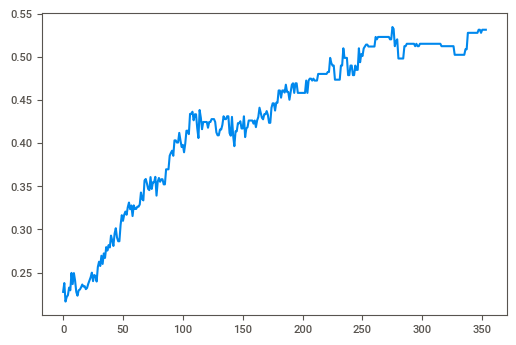

In [352]:
# 学習曲線(評価関数)
print(cv["eval_score-mean"].pop())
plt.plot(cv["eval_score-mean"])

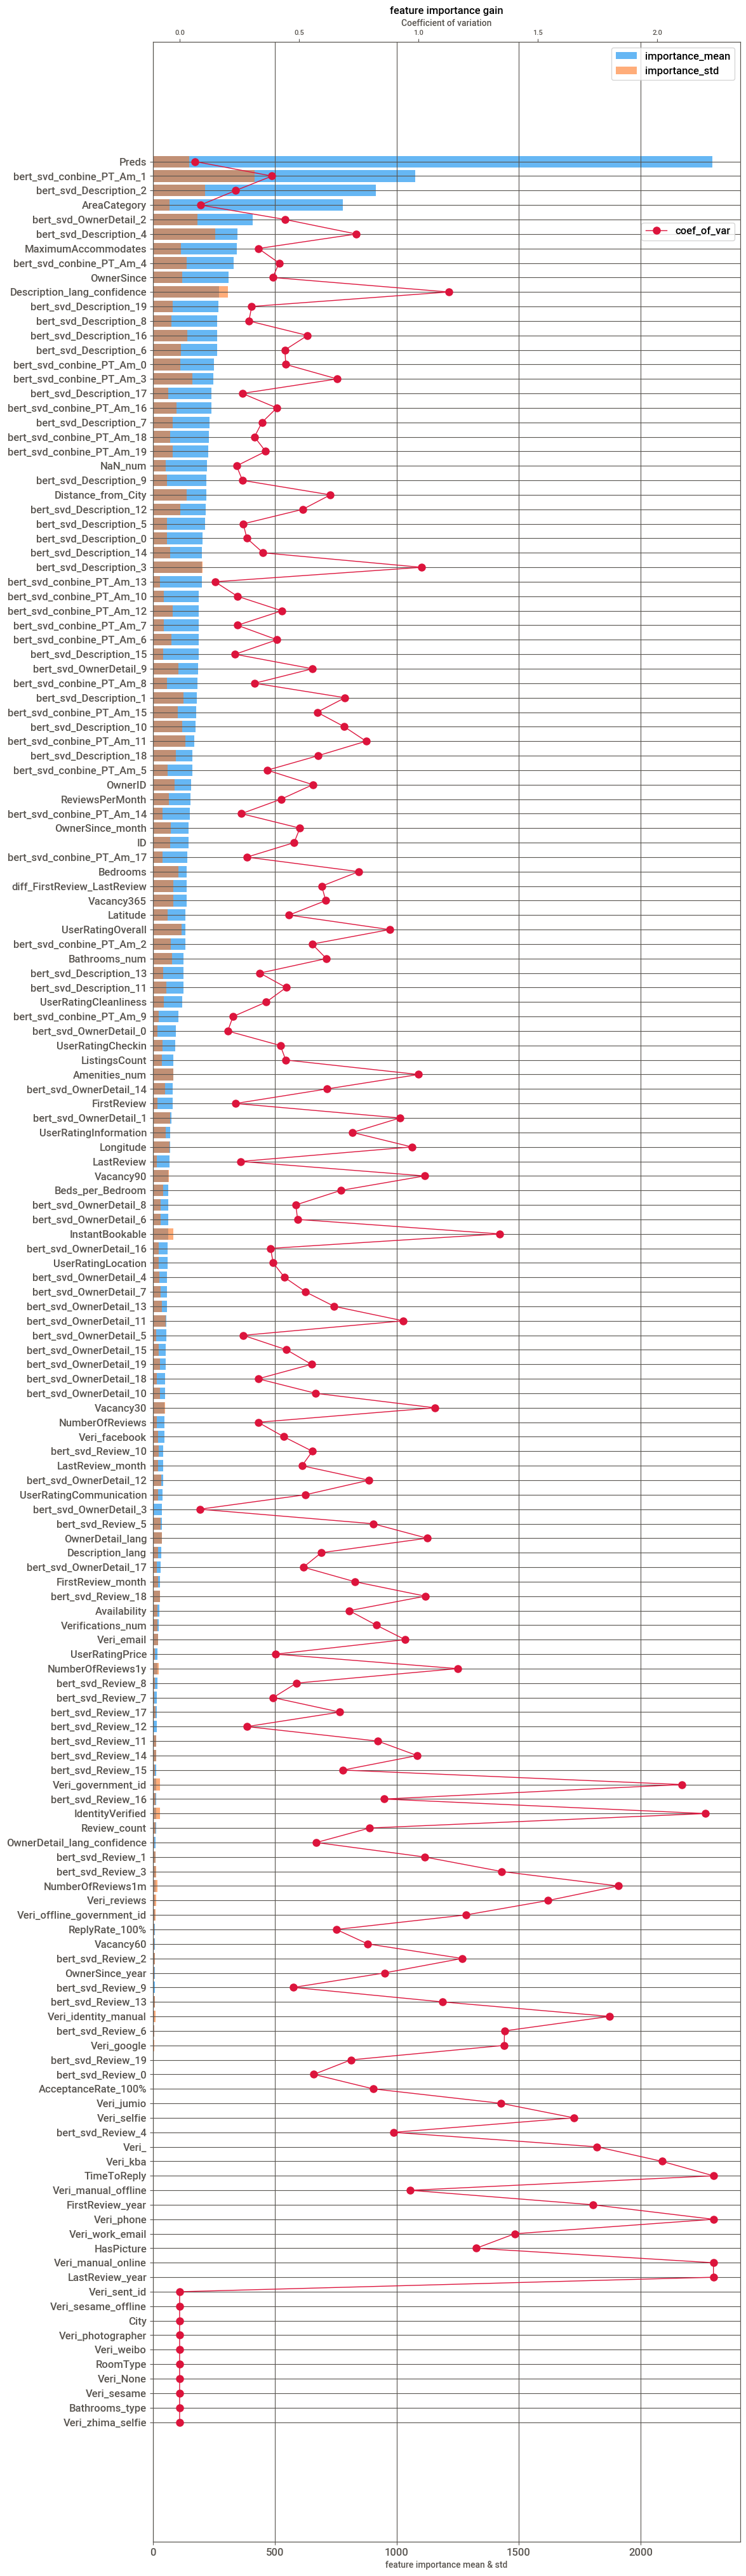

In [353]:
calc_feature_importance(cv_model=model, features=model.boosters[0].feature_name())

In [354]:
# 混合行列
from sklearn.metrics import confusion_matrix, precision_score, recall_score
labels = train_y
preds = np.array(model.predict(train_x)).mean(0)>0.5

In [355]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [356]:
# shap
import shap
# Out-of-Fold なデータで SHAP Value を計算する
split_indices = list(folds.split(train_x, train_y))
cv_shap_values = np.zeros_like(train_x, dtype=np.float)
# Booster と学習に使ったデータの対応関係を取る
booster_split_mappings = list(zip(model.boosters,
                                    split_indices))
for booster, (tr_index, val_index) in booster_split_mappings:
    # Booster が学習に使っていないデータ
    booster_val_x = train_x.iloc[val_index]
    # booster_tr_x = train_x.iloc[tr_index]
    # SHAP Value を計算する
    explainer = shap.TreeExplainer(booster,
                                   feature_perturbation="tree_path_dependent",
                                #    data=booster_val_x,
                                #    model_output='probability',
                                   )
    train_x_shap_values = explainer.shap_values(booster_val_x)
    cv_shap_values[val_index] = train_x_shap_values[0]

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [357]:
import shap
shap.initjs()

In [358]:
booster = model.boosters[0]
X = train_x
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X)

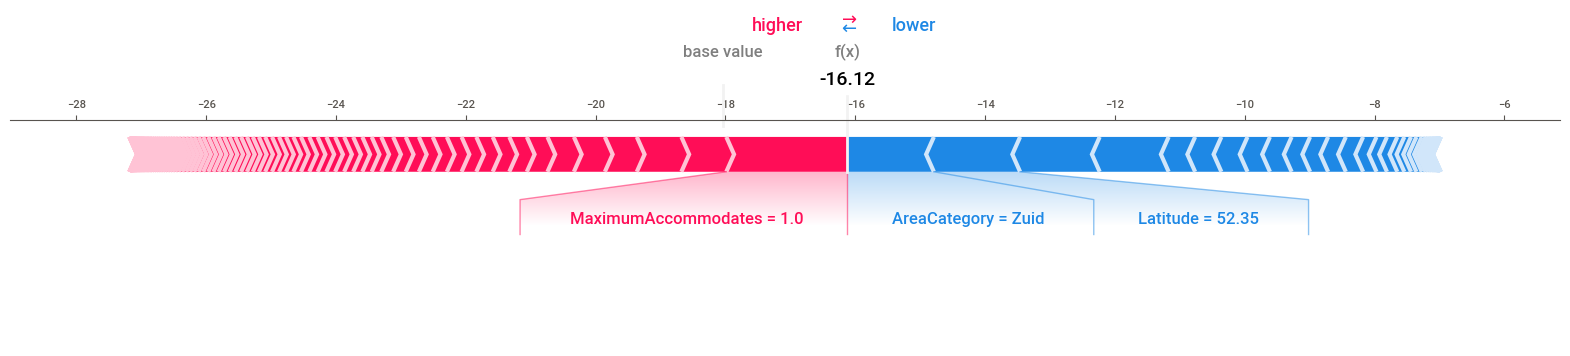

In [359]:
shap.force_plot(explainer.expected_value[1], shap_values[1][2,:], X.iloc[2,:], matplotlib=True)

In [360]:
p = shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X.iloc[:1000,:])
shap.save_html('my_force_plot.html', p)

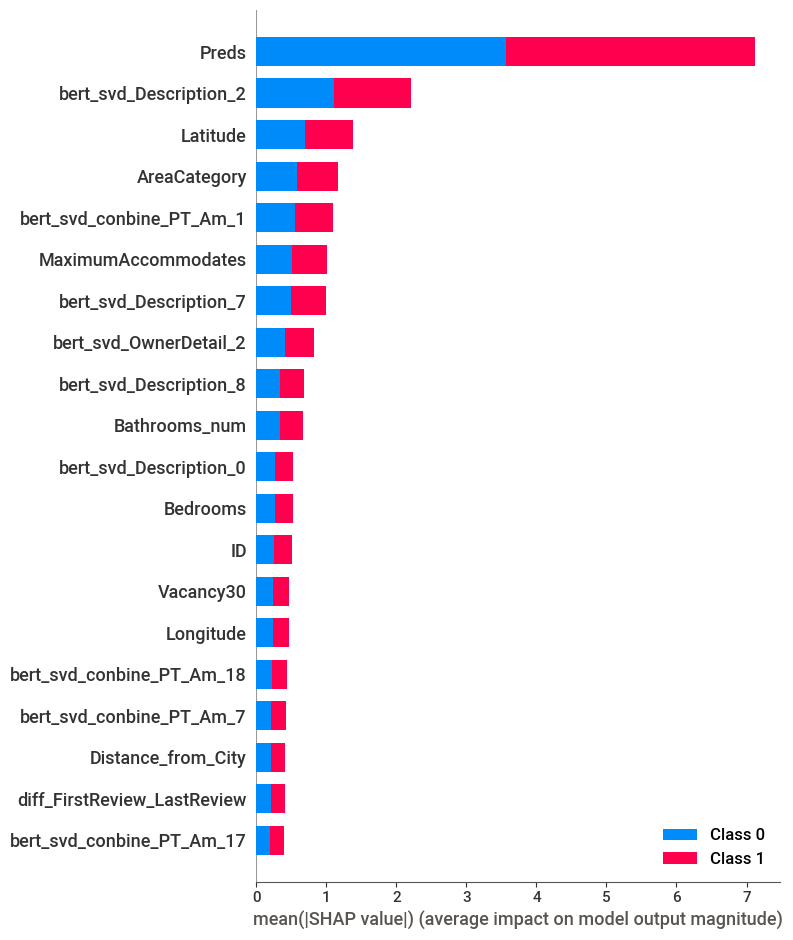

In [361]:
shap.summary_plot(shap_values=shap_values,
                    features=X,
                    feature_names=X.columns)

In [362]:
# for name in X.columns:
#     shap.dependence_plot(name, shap_values[1], X, display_features=X)

In [363]:
# shap.dependence_plot("Preds", shap_values[1], X, display_features=X)

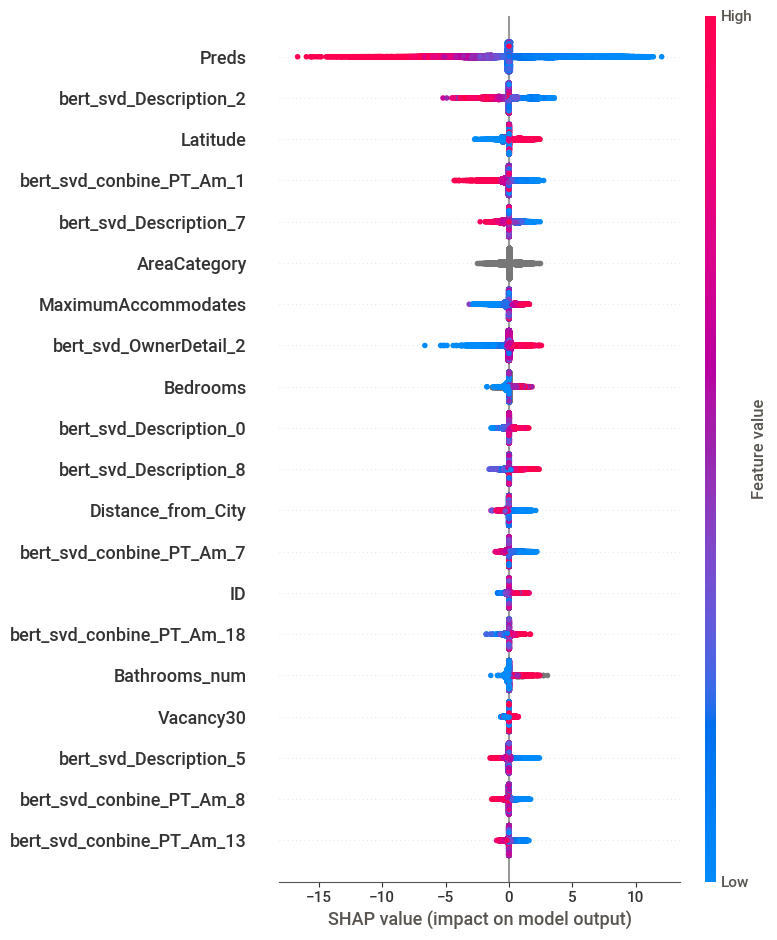

In [364]:
shap.summary_plot(shap_values=cv_shap_values,
                    features=train_x,
                    feature_names=train_x.columns)

In [365]:
# shap.dependence_plot(ind=1,
#                      shap_values=cv_shap_values,
#                      features=train_x,
#                      feature_names=train_x.columns)

# 予測値の保存

In [366]:
def predict_all_df(all_df):
    """全てのデータに対する予測
    """

    # データの準備
    data = all_df.drop(columns=["Price"])
    # 予測：交差検定の各モデルで予測した結果のアンサンブルを最終的な予測結果とする
    preds = np.array(model.predict(data)).mean(axis=0)

    return preds

In [367]:
def save_all_df_preds(all_df):

    # 予測値
    preds = predict_all_df(all_df)

    # dfに格納
    pred_df = all_df.copy()
    pred_df["lightgbm_pred"] = preds
    pred_df = pred_df[["ID", "lightgbm_pred"]]

    # CSVに保存
    dir_path = "/content/drive/MyDrive/competitions/probspace_pricing/data/features/"
    pred_df.to_csv(dir_path + "lightgbm_pred.csv", index=False)

    print("save sucsess !!")

In [368]:
# save_all_df_preds(all_df)

# 提出

In [369]:
def prep_after(submission_df):
    """後処理
    """

    submission_df[submission_df["ID"]==62397] = 1000000

    return submission_df

In [370]:
def make_submission(expm1=True):

    # 交差検定の各モデルで予測した結果をアンサンブルしたものを、最終的な予測結果とする
    if (expm1==True):
        # 対数変換を戻す
        submission = pd.DataFrame({
            "ID": test_x.index,
            "Price": np.expm1(np.array(model.predict(test_x)).mean(axis = 0))})
    else :
        submission = pd.DataFrame({
            "ID": test_x.index,
            "Price": np.array(model.predict(test_x)).mean(axis = 0)})

    submission.to_csv("../data/submission/submission_lgb_{}.csv".format(str(datetime.date.today()))
                    , index = False, header = True)
    
    print("save preds to 「submission_lgb_{}.csv」".format(str(datetime.date.today())))

    return submission

In [371]:
# make_submission(expm1=True)